# SIFT and SVM with Hyperparameter Tuning and Image Drops

SIFT and SVM with hyperparameter tuning and dropping of images.

# Images Related Functions

Functions for displaying images, and images with keypoints.  There is a function for saving images to disk as png files but it is not used in the code below.

In [1]:
# images related functions code
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import random

def display_image(image, title="Image"):
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')  # Hide axis
    plt.show()

def save_image_plot(image, filename, save_dir='plot_outputs'):
    os.makedirs(save_dir, exist_ok=True)
    plt.figure()
    plt.imshow(image, cmap='gray')
    plt.title(filename)
    plt.axis('off')
    save_path = os.path.join(save_dir, f'{filename}.png')
    plt.savefig(save_path)
    plt.close()

def display_image_with_keypoints(image, keypoints, title="Image with Keypoints"):
    # Ensure the image is in the correct range
    image_uint8 = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    img_with_keypoints = cv2.drawKeypoints(image_uint8, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(img_with_keypoints, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

def display_keypoints(images, keypoints_list, num_images=5):
    valid_indices = [i for i, keypoints in enumerate(keypoints_list) if keypoints]
    if len(valid_indices) < num_images:
        num_images = len(valid_indices)
    selected_indices = random.sample(valid_indices, num_images)
    for i in selected_indices:
        display_image_with_keypoints(images[i], keypoints_list[i], title=f"Image {i + 1} with Keypoints")

# Label Loading

In [2]:
# label related code
import scipy.io
import numpy as np

def load_labels(mat_file, num_labels=63445):
    print("Loading labels...")
    labels = scipy.io.loadmat(mat_file)['labels'].flatten()[:num_labels]
    print(f"Loaded {len(labels)} labels.\n")
    return labels

def print_label_distribution(labels):
    unique, counts = np.unique(labels, return_counts=True)
    total = len(labels)
    print("Label Distribution:")
    for label, count in zip(unique, counts):
        percentage = (count / total) * 100
        print(f"Label {label}: {count} ({percentage:.2f}%)")

# Preprocessing

Some main concepts of the preprocessing are of image sizes 64 x 64, normalized pixel values of between 0-1, and Grayscale.

In [3]:
# preprocessing code
import cv2
import numpy as np
import os

def preprocess_images(image_dir, num_images):
    print("Preprocessing images...")
    images = []
    for i in range(1, num_images + 1):
        img_path = os.path.join(image_dir, f"{i}.png")
        if not os.path.exists(img_path):
            print(f"Warning: Image {img_path} not found")
            continue

        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (64, 64))
        image = image / 255.0
        images.append(image)

        if i % 5000 == 0:
            print(f"Processed images {i-4999}-{i}")
    
    print("Finished preprocessing images.\n")
    return np.array(images)

# SIFT Extraction

SIFT extraction code.

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sift_svm_local4_image_utils import display_image_with_keypoints

def extract_sift_features(images, max_features=500):
    print("Extracting SIFT features...")
    sift = cv2.SIFT_create()
    all_descriptors = []
    keypoints_list = []
    valid_images = 0
    
    for i, image in enumerate(images):
        image_uint8 = (image * 255).astype(np.uint8)
        keypoints, descriptors = sift.detectAndCompute(image_uint8, None)
        
        if keypoints and descriptors is not None:
            keypoints_list.append(keypoints)
            if descriptors.shape[0] < max_features:
                padded_descriptor = np.zeros((max_features, 128))
                padded_descriptor[:descriptors.shape[0], :] = descriptors
                all_descriptors.append(padded_descriptor)
            else:
                all_descriptors.append(descriptors[:max_features, :])
            valid_images += 1
        else:
            # Skip images without descriptors
            continue
        
        if (i + 1) % 1000 == 0:
            print(f"Processed SIFT features for {i + 1}/{len(images)} images")

    print(f"SIFT feature extraction completed. Valid images with features: {valid_images}/{len(images)}\n")
    return all_descriptors, keypoints_list

def get_keypoint_statistics(keypoints_list):
    num_keypoints = [len(kp) for kp in keypoints_list if len(kp) > 0]
    avg_keypoints = np.mean(num_keypoints)
    max_keypoints = np.max(num_keypoints)
    min_keypoints = np.min(num_keypoints)
    return avg_keypoints, max_keypoints, min_keypoints

def display_keypoints(images, keypoints_list, num_images):
    for i in range(min(num_images, len(images))):
        display_image_with_keypoints(images[i], keypoints_list[i], title=f"Image {i + 1} with Keypoints")


# Model Building with Hyperparameters

Below is the code mainly to split the data, build the model, set some hyperparameters, train the model, validate it, and then test it.

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

def train_and_evaluate(X, y, sample_size=1000):
    print("Starting training and evaluation...")

    # Convert to float32 to save memory
    X = X.astype(np.float32)

    # Sample 1,000 images directly from the original dataset
    X_sampled, _, y_sampled, _ = train_test_split(X, y, train_size=sample_size, random_state=42)
    print(f"Sampled data shape: {X_sampled.shape}")

    # Split the sampled data into new training, validation, and testing datasets
    X_train, X_temp, y_train, y_temp = train_test_split(X_sampled, y_sampled, test_size=0.4, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    print(f"Sampled data shape: {y_sampled.shape}")

    print(f"Sampled data split: {len(X_train)} training, {len(X_val)} validation, {len(X_test)} testing samples")

    # Standardize the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    print("Data standardized")

    # Define the parameter grid
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': [1, 0.1, 0.01, 0.001],
        'kernel': ['rbf', 'poly', 'sigmoid']
    }

    # Initialize the SVM model
    svm_model = SVC()

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(svm_model, param_grid, refit=True, verbose=2, cv=3)
    print("Performing grid search...")
    grid_search.fit(X_train, y_train)
    print("Grid search completed")

    # Get the best parameters and model
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    print(f"Best parameters found: {best_params}")

    # Validate the model
    print("Validating model...")
    y_val_pred = best_model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy: {val_accuracy}")
    print("Validation Classification Report:")
    print(classification_report(y_val, y_val_pred))

    # Test the model
    print("Testing model...")
    y_test_pred = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Test Accuracy: {test_accuracy}")
    print("Test Classification Report:")
    print(classification_report(y_test, y_test_pred))


Here is our parameter grid for the GridSearch:

 # Define the parameter grid
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': [1, 0.1, 0.01, 0.001],
        'kernel': ['rbf', 'poly', 'sigmoid']
    }

What this does is go through about 140 different combinations of these hyperparameters, and then picks the best setting.

The cross-validation component is in the "perform grid search with cross-validation" part of the code. Specifically, it is implemented using GridSearchCV from sklearn.model_selection.

Data Split Code:

The initial data split code (train_test_split) is used to create separate training, validation, and testing datasets. This is a standard train-test split and is not part of the cross-validation process.

This split ensures that the model is trained on one part of the data and validated/tested on separate parts to evaluate its performance.

Perform Grid Search with Cross-Validation:

The GridSearchCV function performs the cross-validation. It takes the training data and splits it into multiple folds (as specified by the cv parameter, which is set to 3 in this case).

For each combination of hyperparameters in the parameter grid, GridSearchCV trains the model on k-1 folds and validates it on the remaining fold. This process is repeated k times (where k is the number of folds), and the performance metrics are averaged.

This cross-validation process helps to find the best combination of hyperparameters and provides a more reliable estimate of the model's performance.

Summary:

Data Split Code: Creates separate training, validation, and testing datasets.

Grid Search with Cross-Validation: Uses GridSearchCV to perform cross-validation on the training data to tune hyperparameters and evaluate the model's performance.

The cross-validation component is specifically in the GridSearchCV part, which ensures that the model is evaluated on multiple folds of the training data to find the best hyperparameters and provide a robust performance estimate.

# Function Calls

Below are a series of function calls to the functions we have defined.

## Labels

Code on loading the labels from the matlab file, then preprocessing the images, creating the feature matrix we will perform the data splitting on into training, validation, and testing.

In [6]:
# Local directory paths
image_dir = 'cells'  # Directory containing images
mat_file = 'labels.mat'  # Labels file
num_images = 63445

# Load labels and preprocess images
labels = load_labels(mat_file, num_labels=num_images)
print_label_distribution(labels)
images = preprocess_images(image_dir, num_images)

Loading labels...
Loaded 63445 labels.

Label Distribution:
Label 1: 14367 (22.64%)
Label 2: 14655 (23.10%)
Label 3: 13257 (20.90%)
Label 4: 13737 (21.65%)
Label 5: 5086 (8.02%)
Label 6: 2343 (3.69%)
Preprocessing images...
Processed images 1-5000
Processed images 5001-10000
Processed images 10001-15000
Processed images 15001-20000
Processed images 20001-25000
Processed images 25001-30000
Processed images 30001-35000
Processed images 35001-40000
Processed images 40001-45000
Processed images 45001-50000
Processed images 50001-55000
Processed images 55001-60000
Finished preprocessing images.



## SIFT

In [7]:
# Extract SIFT features
image_features, keypoints_list = extract_sift_features(images)

Extracting SIFT features...
Processed SIFT features for 9000/63445 images
Processed SIFT features for 10000/63445 images
Processed SIFT features for 12000/63445 images
Processed SIFT features for 13000/63445 images
Processed SIFT features for 23000/63445 images
Processed SIFT features for 24000/63445 images
Processed SIFT features for 25000/63445 images
Processed SIFT features for 26000/63445 images
Processed SIFT features for 27000/63445 images
Processed SIFT features for 28000/63445 images
Processed SIFT features for 29000/63445 images
Processed SIFT features for 31000/63445 images
Processed SIFT features for 33000/63445 images
Processed SIFT features for 38000/63445 images
Processed SIFT features for 39000/63445 images
Processed SIFT features for 40000/63445 images
Processed SIFT features for 41000/63445 images
Processed SIFT features for 42000/63445 images
Processed SIFT features for 43000/63445 images
Processed SIFT features for 45000/63445 images
Processed SIFT features for 47000

## Drop Images Without Descriptors

In [8]:
# Filter out images without descriptors
valid_indices = [i for i, desc in enumerate(image_features) if desc is not None]
image_features = [image_features[i] for i in valid_indices]
labels = [labels[i] for i in valid_indices]

## Keypoint Statistics

In [10]:
# Get keypoint statistics
avg_keypoints, max_keypoints, min_keypoints = get_keypoint_statistics(keypoints_list)
print(f"Average number of keypoints: {avg_keypoints}")
print(f"Maximum number of keypoints: {max_keypoints}")
print(f"Minimum number of keypoints: {min_keypoints}")

Average number of keypoints: 7.649211356466877
Maximum number of keypoints: 59
Minimum number of keypoints: 1


## Display Images With Keypoints

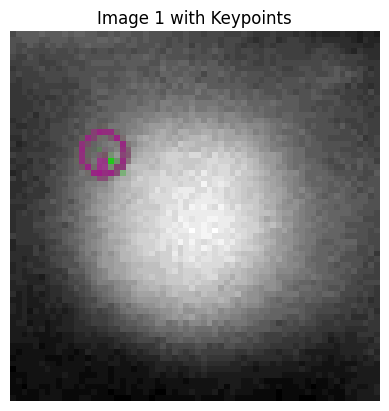

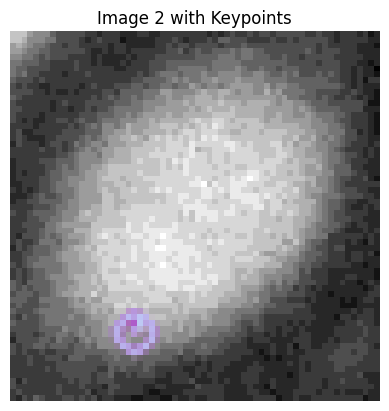

In [14]:
# Display keypoints on a few images
display_keypoints(images, keypoints_list, num_images=2)

## Flatten

This is a process of converting the data type to a 1 dimensional array.

In [15]:
# Flatten the list of descriptors and create a feature matrix
X = np.array([desc.flatten() for desc in image_features])
y = np.array(labels)

## Split, Train, Validate, and Test

In [16]:
# Train and evaluate the model
train_and_evaluate(X, y)

Starting training and evaluation...
Sampled data shape: (1000, 64000)
Sampled data shape: (1000,)
Label distribution in sampled data:
Label Distribution:
Label 1: 467 (46.70%)
Label 2: 491 (49.10%)
Label 3: 42 (4.20%)
Label Distribution:
Label 1: 268 (44.67%)
Label 2: 306 (51.00%)
Label 3: 26 (4.33%)
Sampled data split: 600 training, 200 validation, 200 testing samples
Data standardized
Performing grid search...
Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.4s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.3s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.5s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   2.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   1.9s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   1.8s
[CV] END .....................C=0.1,

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Test Accuracy: 0.725
Test Classification Report:
              precision    recall  f1-score   support

           1       0.79      0.65      0.72        98
           2       0.68      0.84      0.75        96
           3       0.00      0.00      0.00         6

    accuracy                           0.72       200
   macro avg       0.49      0.50      0.49       200
weighted avg       0.71      0.72      0.71       200



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

The scores here with dropping non-descriptor images and using hyperparameter tuning with GridSearch give the best scores.  Test accuracy of about 73% is very good.  Without the GridSearch we get about 70%.  Just SVM was giving about 50%.  SVM with SIFT without dropping images gives about 40%.